# Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
df=pd.read_csv("Gold Price (2013-2023).csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.drop(columns=["Vol.","Change %","Open","High","Low"])
df.sort_values(by="Date",inplace=True)

In [5]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [6]:
prices = df['Price'].values  
prices_reshaped = prices.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(prices_reshaped)
print(normalized_data.shape)

(2583, 1)


In [7]:
df.head()

,Date,Price
2582,2013-01-02,1689.9
2581,2013-01-03,1675.6
2580,2013-01-04,1649.9
2579,2013-01-07,1647.2
2578,2013-01-08,1663.2


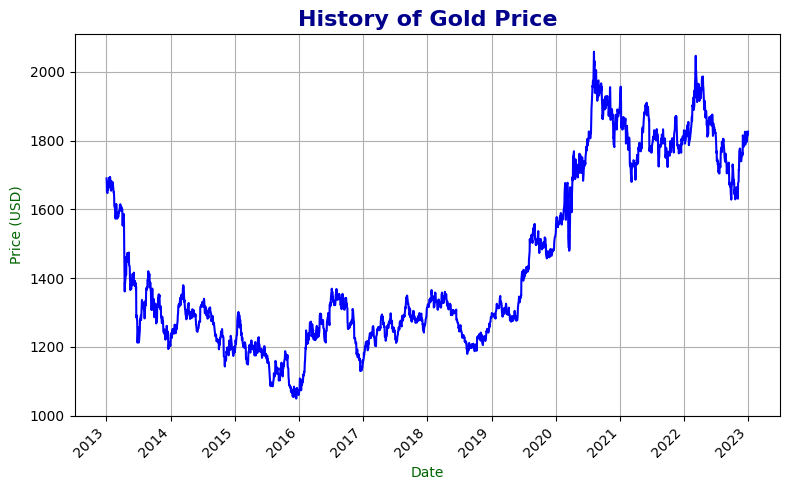

In [8]:
plt.figure(figsize=(8,5 )) 
plt.plot(df['Date'], df['Price'], color='blue',  markersize=6) 
plt.title('History of Gold Price', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Date', fontsize=10, color='darkgreen') 
plt.ylabel('Price (USD)', fontsize=10, color='darkgreen') 
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
ratio=0.80
train_size=int(len(df)*ratio)
test_size=len(df)-train_size
train_data,test_data=normalized_data[:train_size],normalized_data[train_size:]
print(f"all data: {len(df)}\ntrain data: {train_size}\ntest data: {test_size}")

all data: 2583
train data: 2066
test data: 517


In [10]:
def create_dataset(dataset, time_step_in=1,time_step_out=1):
    X, Y = [], []

    for i in range(len(dataset) - time_step_in - time_step_out):
        a = dataset[i:(i + time_step_in), 0]
        X.append(a)
        
        b = dataset[(i + time_step_in):(i + time_step_in + time_step_out), 0]  
        Y.append(b)
    
    return np.array(X), np.array(Y)

In [11]:
time_step_in=30
time_step_out=30
X_train,y_train=create_dataset(train_data,time_step_out,time_step_in)
X_test,y_test=create_dataset(test_data,time_step_out,time_step_in)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (2006, 30) 
y_train: (2006, 30)
X_test: (457, 30)
y_test: (457, 30)


In [12]:
model=Sequential()
model.add(Dense(512,input_shape=(30,),activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(30))
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
model.summary()

c:\Python_Projects\MachineLearning.khorsand\Alzimer\face\f\gold_price\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        15,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,862 (362.74 KB)

 Trainable params: 92,862 (362.74 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history=model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=1
    )

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2467 - mean_absolute_error: 0.2467 - val_loss: 0.4538 - val_mean_absolute_error: 0.4538
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1658 - mean_absolute_error: 0.1658 - val_loss: 0.3406 - val_mean_absolute_error: 0.3406
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1300 - mean_absolute_error: 0.1300 - val_loss: 0.2747 - val_mean_absolute_error: 0.2747
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1089 - mean_absolute_error: 0.1089 - val_loss: 0.2109 - val_mean_absolute_error: 0.2109
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0812 - mean_absolute_error: 0.0812 - val_loss: 0.1487 - val_mean_absolute_error: 0.1487
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0627 - mean_absolute_error: 0.0627 - val_loss: 0.0988 - val_mean_absolute_error: 0.0988
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss

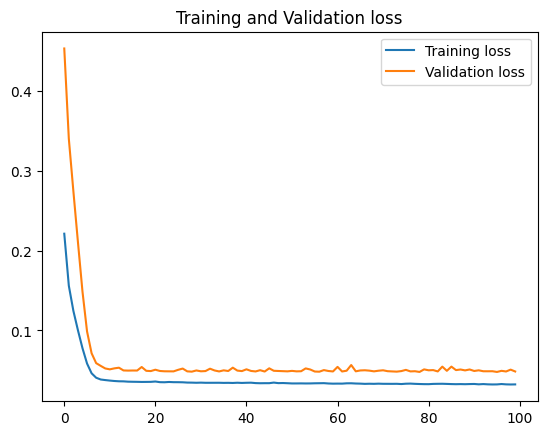

In [14]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [15]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0487 - mean_absolute_error: 0.0487 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [16]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [17]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: [0.04848744720220566, 0.04848744720220566]
Test MAPE: 0.06541160258061642
Test Accuracy: 0.9345883974193836


In [25]:
X_test=scaler.inverse_transform(X_test)
X_train=scaler.inverse_transform(X_train)

In [27]:
X_test[-1]

array([1709.3, 1675.2, 1686. , 1677.5, 1677. , 1643.7, 1658.9, 1650.7,
       1629. , 1631.8, 1651.5, 1649.2, 1653.3, 1664.4, 1660.3, 1644.8,
       1640.7, 1649.7, 1650. , 1630.9, 1676.6, 1680.5, 1716. , 1713.7,
       1753.7, 1769.4, 1776.9, 1776.8, 1775.8, 1763. ])

In [26]:
y_next_30=model.predict(X_test[-1].reshape(1,-1))
y_next_30=np.round(y_next_30)
y_next_30

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[1725., 1743., 1788., 1732., 1717., 1755., 1766., 1733., 1721.,
        1736., 1703., 1770., 1735., 1736., 1785., 1685., 1736., 1780.,
        1757., 1735., 1776., 1795., 1812., 1754., 1808., 1735., 1758.,
        1750., 1745., 1760.]], dtype=float32)

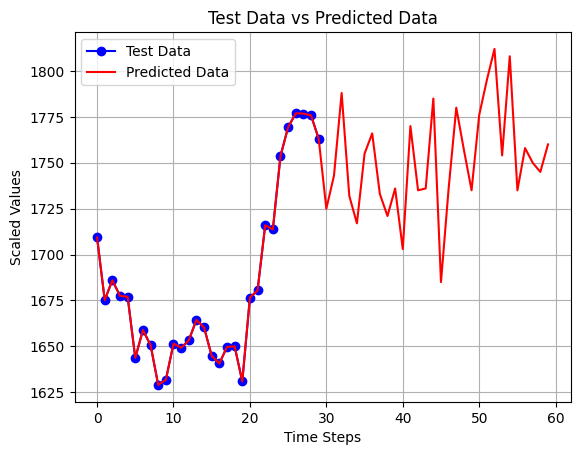

In [28]:
plt.plot(X_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([X_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()